In [1]:
import numpy as onp
import matplotlib.pyplot as plt

import jax.numpy as np 
from jax import grad, jit, vmap

from astropy.table import Table

from jax.config import config
config.update("jax_enable_x64", True)

%matplotlib inline

Now we are going to define functions for the discrete Fourier transform, giving us the 1-sided and 2-sided DFTM.

In [2]:
def compute_DFTM1(x,y,uv,wavel):
    '''Compute a direct Fourier transform matrix, from coordinates x and y (milliarcsec) to uv (metres) at a given wavelength wavel.'''

    # Convert to radians
    x = x * np.pi / 180.0 / 3600.0/ 1000.0
    y = y * np.pi / 180.0 / 3600.0/ 1000.0

    # get uv in nondimensional units
    uv = uv / wavel

    # Compute the matrix
    dftm = np.exp(-2j* np.pi* (np.outer(uv[:,0],x)+np.outer(uv[:,1],y)))

    return dftm

def apply_DFTM1(image,dftm):
    '''Apply a direct Fourier transform matrix to an image.'''
    image /= image.sum()
    return np.dot(dftm,image.ravel())

In [3]:
pscale = 66/10 # mas/pixel - for round numbers, 10x better than JWST NIRISS
wavel = 4.3e-6 # m

x = np.arange(80)*pscale - 80*pscale/2
y = x.copy()
xx, yy = np.meshgrid(x,y)


In [4]:
u, v = np.linspace(-50,50,64), np.linspace(-50,50,64)

uu, vv = np.meshgrid(np.linspace(-50,50,64),np.linspace(-50,50,64))
uvgrid = np.vstack((uu.flatten(),vv.flatten())).T
dftm_test = compute_DFTM1(xx, yy, uvgrid, wavel)

Let's test this with a simple circular aperture:

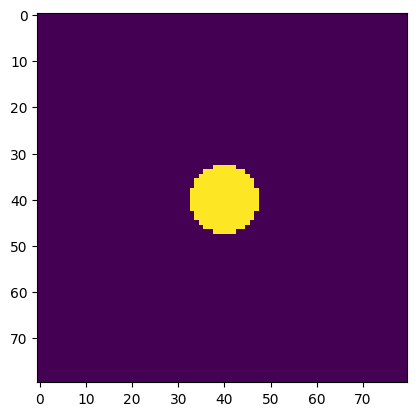

In [5]:
rr = np.sqrt(xx**2 + yy**2)
circular_star = 1.0*(rr<50)
plt.imshow(circular_star)

0.961905986036081


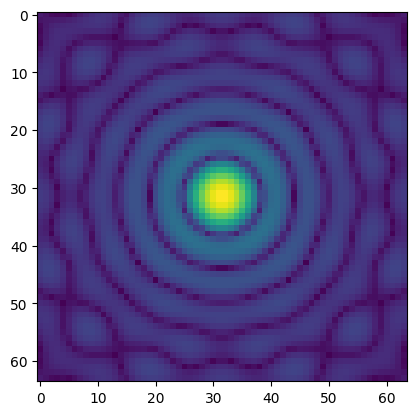

In [6]:
out = apply_DFTM1(circular_star,dftm_test).reshape(64,64)
v2, phase = np.abs(out)**2, np.angle(out)
print(v2.max())
plt.imshow(v2**0.25)

Verify that this looks like the Airy pattern we know and love:

In [7]:
from scipy.special import j1
mas2rad = np.pi / 180.0 / 3600.0/ 1000.0

def airy(uv, lam, diam):
    '''Airy function for a circular aperture, evaluated on baselines uv (m) with diameter diam (mas) at wavelength lam (m)'''
    
    r = np.sqrt(uv[:,0]**2 + uv[:,1]**2)/wavel

    d = diam*mas2rad

    return 2 * j1(np.pi * r * d) / (np.pi * r * d)

In [8]:
diam = 100 # mas
airy_disk = airy(uvgrid, wavel, diam)

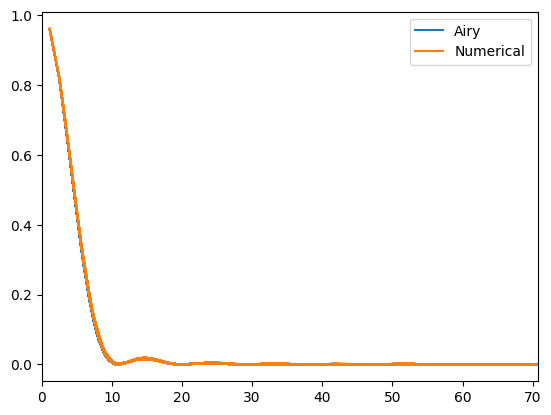

In [9]:
wgrid = np.sqrt(uvgrid[:,0]**2 + uvgrid[:,1]**2)

plt.plot(wgrid, airy_disk**2, label='Airy')
plt.plot(wgrid, v2.ravel(), label='Numerical')

plt.xlim(0,wgrid.max())
plt.legend()

Looks good enough to me! 

Now let's do the 2-sided DFT method, which is valid only where you have a uniform grid in and out.

In [10]:
def compute_DFTM2(input_coordinates, output_coordinates, axis=0):
    '''
    Compute a 2-sided direct Fourier transform matrix, from coordinates x and y (milliarcsec) 
    to uv (metres) at a given wavelength wavel.

    Parameters
    ----------
    steps_in : tuple
        (x_step, y_step) in milliarcsec
    array_sizes : tuple
        (x_size, y_size) in pixels
    wavel : float
        Wavelength in metres
    pscale : float
        Pixel scale in milliarcsec
    axis : int
        Axis to compute DFTM along

    Returns
    -------
    ftm : 2D array
        One axis DFT matrix
    '''

    input_to_output = np.outer(input_coordinates, output_coordinates)

    ftm = np.exp(2. * np.pi * 1j * input_to_output)

    if axis != 0:
        return ftm
    else:
        return ftm.T

def both_DFTM2(u, v, img_size, wavel, pscale):
    '''Compute a 2-sided direct Fourier transform matrix, from coordinates x and y (milliarcsec) 
    to uv (metres) at a given wavelength wavel.
    
    Parameters
    ----------
    uv : 2D array
        Baselines in metres
    img_size : int
        Image size in pixels
    pscale : float
        Pixel scale in mas/pixel
    wavel : float
        Wavelength in metres
    
    Returns
    -------
    LL, RR : 2D arrays
        Left and Right DFT matrices
    '''

    # Compute the matrix
    output_coordinates = u/wavel

    input_coordinates = (np.arange(img_size) - img_size/2)*pscale*mas2rad

    LL = compute_DFTM2(input_coordinates, output_coordinates, axis=0)
    
    # Compute the other matrix
    output_coordinates = v/wavel
    input_coordinates = (np.arange(img_size) - img_size/2)*pscale*mas2rad

    RR = compute_DFTM2(input_coordinates, output_coordinates, axis=1)
    return LL, RR


def apply_dftm2(image,u, v, pscale, wavel):
    '''Apply a 2-sided direct Fourier transform matrix to an image.    

    Parameters
    ----------
    image : 2D array
        Image to be transformed
    uv : 2D array
        Baselines in metres
    pscale : float
        Pixel scale in mas/pixel
    wavel : float
        Wavelength in metres

    Returns
    -------
    FT : 2D array
        Fourier transform of the image
    '''

    image /= np.sum(image)

    img_size = image.shape[0]

    LL, RR = both_DFTM2(u, v, img_size, wavel, pscale)
    
    FT = np.dot(LL, np.dot(image, RR))

    return FT

In [11]:
twosided = apply_dftm2(circular_star, u, v, pscale, wavel)

v2_two, phase_two = np.abs(twosided)**2, np.angle(twosided)

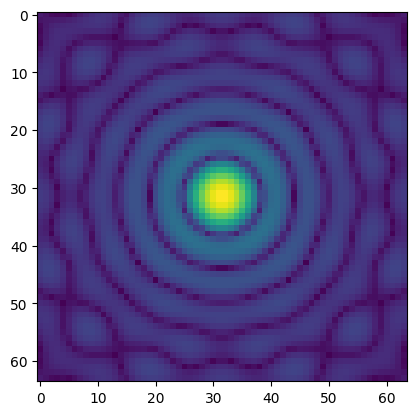

In [12]:
plt.imshow(v2_two**0.25)

Now we're ready to wrap these up as Zodiax objects.

In [13]:
from zodiax import Base # use this for object oriented Jax


In [14]:
Array = np.ndarray
from equinox import static_field

class UVGrid(Base):
    '''
    A Zodiax layer to do a 2D Fourier transform of an image onto a uniformly-sampled uv plane grid 
    using a 2-sided matrix Fourier transform.
    '''
    u: Array = static_field()
    v: Array = static_field()
    pscale: float = static_field()
    wavel: float = static_field()
    img_size: int = static_field()
    LL: Array = static_field()
    RR: Array = static_field()

    def __init__(self, u, v, pscale, wavel, img_size):
        '''
        Parameters
        ----------
        u : 1D array
            u coordinates of the baselines in metres
        v : 1D array
            v coordinates of the baselines in metres
        pscale : float
            Pixel scale in mas/pixel
        wavel : float
            Wavelength in metres
        img_size : int
            Image size in pixels
        '''
        self.u = u
        self.v = v
        self.pscale = pscale
        self.wavel = wavel
        self.img_size = img_size

        self.LL, self.RR = both_DFTM2(u, v, img_size, wavel, pscale)

    def __call__(self,image):
        '''
        Apply a 2-sided direct Fourier transform matrix to an image.

        Parameters
        ----------
        image : 2D array
            Image to be transformed

        Returns
        -------
        FT : 2D array
            Fourier transform of the image
        '''

        image /= np.sum(image)

        FT = np.dot(self.LL, np.dot(image, self.RR))
        return FT

class UVNonUniform(Base):
    '''
    A Zodiax layer to do a 1D Fourier transform of an image onto an arbitrary uv array 
    using a 1-sided matrix Fourier transform. Output will not by default be image-shaped.
    '''

    uv: Array = static_field()
    x: Array = static_field()
    y: Array = static_field()
    wavel: float = static_field()
    DFTM: Array = static_field()

    def __init__(self, uv, x, y, wavel):
        '''
        Parameters
        ----------
        uv : 2D array
            uv coordinates of the baselines in metres
        x : 1D array
            x coordinates of the image in milliarcsec
        y : 1D array
            y coordinates of the image in milliarcsec
        wavel : float
            Wavelength in metres

        '''
        self.uv = uv
        self.x = x
        self.y = y
        self.wavel = wavel
        
        self.DFTM = compute_DFTM1(self.x,self.y,uv,self.wavel)

    def __call__(self,image):
        '''
        Apply a 2-sided direct Fourier transform matrix to an image.

        Parameters
        ----------
        image : 2D array
            Image to be transformed

        Returns
        -------
        FT : 2D array
            Fourier transform of the image
        '''

        image /= np.sum(image)

        FT = np.dot(self.DFTM, image.ravel())#.reshape(self.u.shape[0], self.uv.shape[1])
        return FT

Let's verify that they give you the same results: first, the 2D grid.

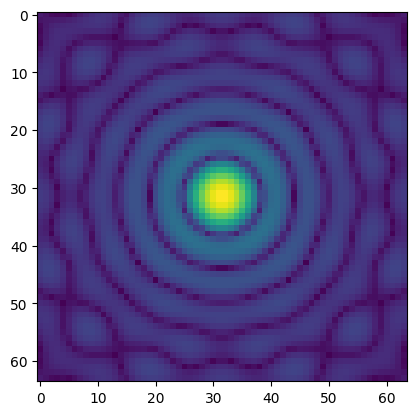

In [15]:
operator = UVGrid(u, v, pscale, wavel, circular_star.shape[0])
out_zx = operator(circular_star)
v2_zx, phase_zx = np.abs(out_zx)**2, np.angle(out_zx)
plt.imshow(v2_zx**0.25)

Now the 1D operator:

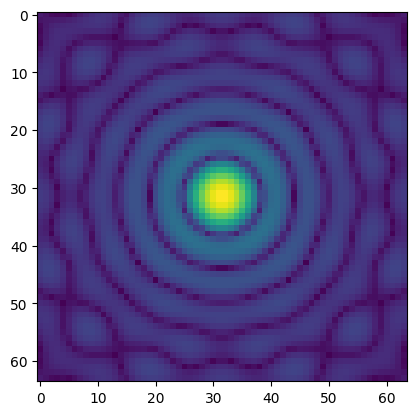

In [16]:
operator2 = UVNonUniform(uvgrid, xx, yy, wavel)
out_zx2 = operator2(circular_star).reshape(64,64) # have to manually reshape - this is for nonuniform grids that won't in general be nice images
v2_zx2, phase_zx2 = np.abs(out_zx2)**2, np.angle(out_zx2)
plt.imshow(v2_zx2**0.25)

Residuals are close to machine precision:

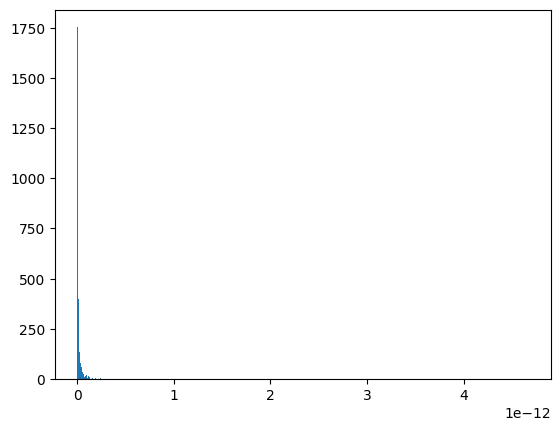

In [18]:
plt.hist((np.abs(v2_zx-v2_zx2)/(v2_zx)).flatten(),bins=1000); # residuals 
# plt.xlim(0,0.00025)
# plt.colorbar()